# Mapping changing water extents through time

* **Products used:** 
[s2_l2a](https://explorer.digitalearth.africa/products/s2_l2a)



## Background
The United Nations have prescribed 17 "Sustainable Development Goals" (SDGs). This notebook attempts to monitor SDG Indicator 6.6.1 - change in the extent of water-related ecosystems. Indicator 6.6.1 has 4 sub-indicators:

>    i. The spatial extent of water-related ecosystems <br>
>    ii. The quantity of water contained within these ecosystems <br>
>    iii. The quality of water within these ecosystems <br>
>    iv. The health or state of these ecosystems <br>

This notebook primarily focuses on the first sub-indicator - spatial extents.

Water extent is estimated using Sentinel-2 satellite images and the Modified Normalised Difference Water Index (MNDWI).


## Description
The notebook loads Setinel-2 data for a given shapefile (the Ruko Conservancy in the default example) and calculates the changing water extent of Lake Baringo and surrounds.  

The following steps are taken:

1. Load and view the analyis region as defined by the input vector file
2. Load cloud-masked Sentinel-2 satellite images
3. Buffer the S2 cloud mask to improve its quality
3. Mask the satellite data with the vector file
4. Calculate the MNDWI
5. Resample the time-series to seasonal medians to reduce noise and gaps in the data
6. Calculate and plot the water extent (in square kilometres) per time-step, 
7. Determine the time when the maximum and minimum water extents occurred
8. Generate an animation of the seasonal MNDWI plots
9. Compare the ewater extent between two nominated time-periods and plot a map of the changes. 

***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

# Force GeoPandas to use Shapely instead of PyGEOS
# In a future release, GeoPandas will switch to using Shapely by default.
import os
os.environ['USE_PYGEOS'] = '0'

import datacube
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import geopandas as gpd

from IPython.display import Image
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from odc.ui import image_aspect
from datacube.utils import geometry

from deafrica_tools.datahandling import load_ard
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.plotting import xr_animation, map_shapefile
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.spatial import xr_rasterize

from datacube.utils.aws import configure_s3_access
configure_s3_access(aws_unsigned=True, cloud_defaults=True)

## Set up a Dask cluster

Dask can be used to better manage memory use and conduct the analysis in parallel. 
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

To use Dask, set up the local computing cluster using the cell below.

In [ ]:
create_local_dask_cluster()

### Analysis parameters

The following cell sets the parameters, which define the area of interest and the length of time to conduct the analysis over.

The parameters are:

* `vector_file`: A shape file that defines the area to analyze.
* `products`: The products to load from the datacube, e.g. `'s2_l2a``
* `time_range`: The date range to analyse (e.g. `('2017', '2019')`.
* `min_gooddata`: This value sets the minimum amount of good data a scene must have before it will be loaded into memory e.g. `0.75` means only images with 75% good data will be retained.
* `measurements`: The spectral bands to load from the satellite product. MNDWI requires the green and swir1 bands, and cloud buffer requires the SCL band
* `resolution`: The pixel resolution of the satellite data.
* `dask_chunks`: Chunk sizes to use for dask, the default values below are optimized for the Ruko Conservancy at 20m resolution.

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The default area is the Ruko Conservancy. 


In [3]:
vector_file = 'data/Ruko_conservancy.geojson'

products = ['s2_l2a']

time_range = ('2017', '2021-02')

min_gooddata = 0.0

measurements = ['green','swir_1', 'SCL']

resolution = (-20,20)

dask_chunks = {'time':1,'x':1250,'y':1250}


### Connect to the datacube

Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [4]:
dc = datacube.Datacube(app='water_extent_shape')

## View the Area of Interest on an interative map
The next cell will  first open the vector file and then display the selected area on an interactive map.
Zoom in and out to get a better understanding of the area of interest.

In [5]:
#read shapefile
gdf = gpd.read_file(vector_file)

map_shapefile(gdf, attribute='id')

Label(value='')

Map(center=[0.6480841040610879, 36.12258148195494], controls=(ZoomControl(options=['position', 'zoom_in_text',…

## Load cloud-masked Sentinel-2 data

The first step is to load Sentinel-2 data for the specified area of interest and time range. 
The `load_ard` function is used here to load data that has been masked for cloud, shadow and quality filters, making it ready for analysis.

The cell directly below will create a query object using the first geometry in the shapefile, along with the parameters we defined in the Analysis Parameters section above.

In [6]:
#create a geom object from the vector file
geom = geometry.Geometry(gdf.iloc[0].geometry.__geo_interface__,
                         geometry.CRS(f'EPSG:{gdf.crs.to_epsg()}'))

water_query = {'time': time_range,
               'measurements': measurements,
               'resolution': resolution,
               'output_crs': 'EPSG:6933',
               'dask_chunks': dask_chunks,
               'geopolygon': geom,
               'group_by':'solar_day'
              }

Now load the satellite data

In [7]:
filters=[('erosion', 5),("closing", 2),("opening", 2),("dilation", 1)]

ds = load_ard(dc=dc,
              products=products,
              min_gooddata=min_gooddata,
              mask_filters=filters,
              **water_query
                   )
print(ds)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying morphological filters to pq mask [('erosion', 5), ('closing', 2), ('opening', 2), ('dilation', 1)]
Applying pixel quality/cloud mask
Returning 279 time steps as a dask array
<xarray.Dataset>
Dimensions:      (time: 279, y: 1194, x: 607)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-02T08:07:11 ... 2021-02-25T08:...
  * y            (y) float64 9.461e+04 9.459e+04 ... 7.077e+04 7.075e+04
  * x            (x) float64 3.479e+06 3.479e+06 ... 3.491e+06 3.491e+06
    spatial_ref  int32 6933
Data variables:
    green        (time, y, x) float32 dask.array<chunksize=(1, 1194, 607), meta=np.ndarray>
    swir_1       (time, y, x) float32 dask.array<chunksize=(1, 1194, 607), meta=np.ndarray>
    SCL          (time, y, x) uint8 dask.array<chunksize=(1, 1194, 607), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


## Mask the satellite data with vector file

Then we'll remove the SCL band as we no longer require it, and convert the data back to float32 to conserve memory (running `.where()` operations converts data to float64 by default).

In [8]:
#create mask
mask = xr_rasterize(gdf,ds)

#mask data
ds = ds.where(mask)

#remove SCL since we don't need it anymore
ds = ds.drop('SCL')

#convert to float 32 to conserve memory
ds=ds.astype(np.float32)

## Calculate the MNDWI water index

In [9]:
# Calculate the chosen vegetation proxy index and add it to the loaded data set
ds = calculate_indices(ds=ds, index='MNDWI', satellite_mission='s2')

# drop green and swir since we don't need it
ds = ds.drop(['green','swir_1'])

## Resample time series

Due to many factors (e.g. cloud obscuring the region, missed cloud cover in the SCL layer) the data will be gappy and noisy. Here, we will resample the data to ensure we working with a consistent time-series.

To do this we resample the data to seasonal time-steps using medians

These calculations will take several minutes to complete as we will run `.compute()`, triggering all the tasks we scheduled above and bringing the arrays into memory.

In [10]:
sample_frequency="QS-DEC"  # quatrley starting in DEC, i.e. seasonal

#resample MNDWI using medians
print('calculating MNDWI medians')
mndwi = ds['MNDWI'].resample(time=sample_frequency).median().compute()


calculating MNDWI medians


/usr/local/lib/python3.10/dist-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


### Facet plot the MNDWI time-steps

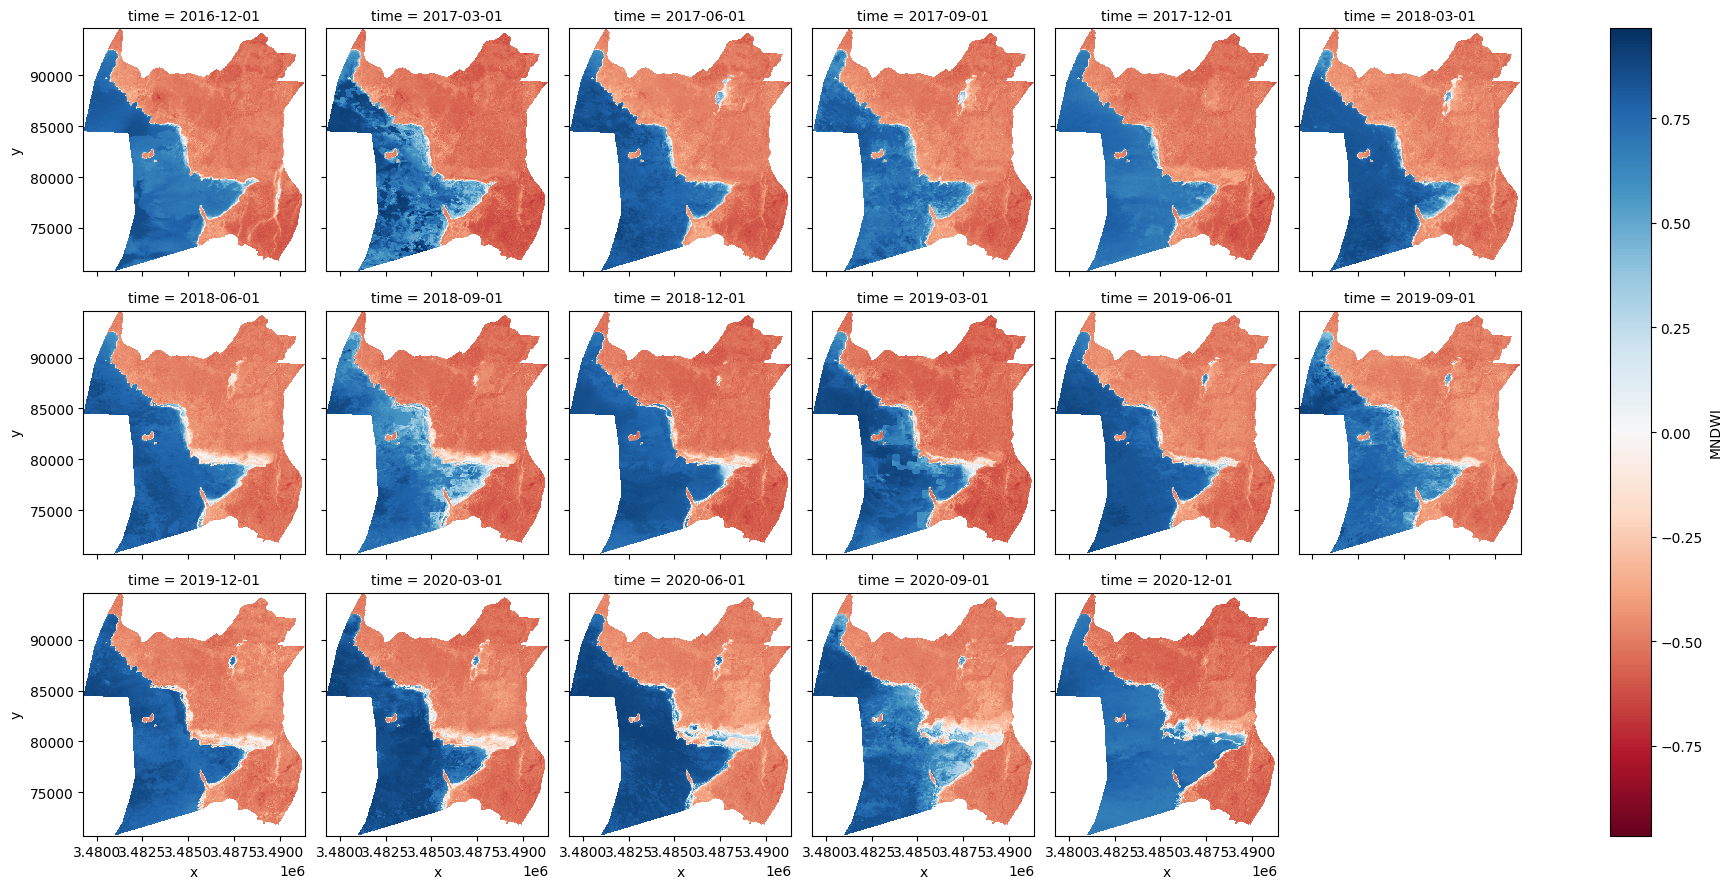

In [11]:
mndwi.plot(col='time', col_wrap=6, cmap='RdBu');

## Calculate the water extent per time-step

The number of pixels can be used for the area of the waterbody if the pixel area is known. 
Run the following cell to generate the necessary constants for performing this conversion.

In [12]:
pixel_length = water_query["resolution"][1]  # in metres
m_per_km = 1000  # conversion from metres to kilometres
area_per_pixel = pixel_length**2 / m_per_km**2

## Calculating the extent of water
Calculates the area of pixels classified as water (if MNDWI is > 0, the water)

In [13]:
water = mndwi.where(mndwi > 0, np.nan)

area_ds = water.where(np.isnan(water),1)

ds_valid_water_area = area_ds.sum(dim=['x', 'y']) * area_per_pixel

### Plot monthly time series of water area

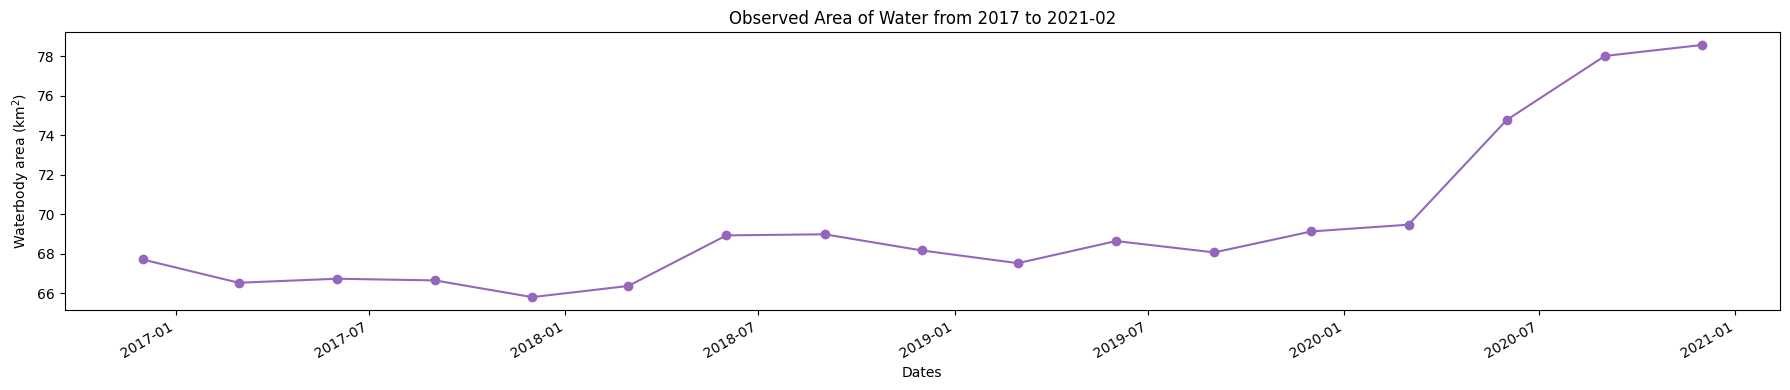

In [14]:
plt.figure(figsize=(18, 4))
ds_valid_water_area.plot(marker='o', color='#9467bd')
plt.title(f'Observed Area of Water from {time_range[0]} to {time_range[1]}')
plt.xlabel('Dates')
plt.ylabel('Waterbody area (km$^2$)')
plt.tight_layout()

## Determine minimum and maximum water extent

The next cell extracts the date of the minimum and maximum extent of water from the dataset using the `min` and `max` functions, we then add the dates to an `xarray.DataArray`.

In [15]:
min_water_area_date, max_water_area_date =  min(ds_valid_water_area), max(ds_valid_water_area)
time_xr = xr.DataArray([min_water_area_date.time.values, max_water_area_date.time.values], dims=["time"])

print(time_xr)

<xarray.DataArray (time: 2)>
array(['2017-12-01T00:00:00.000000000', '2020-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Dimensions without coordinates: time


### Plot the dates when the min and max water extent occur


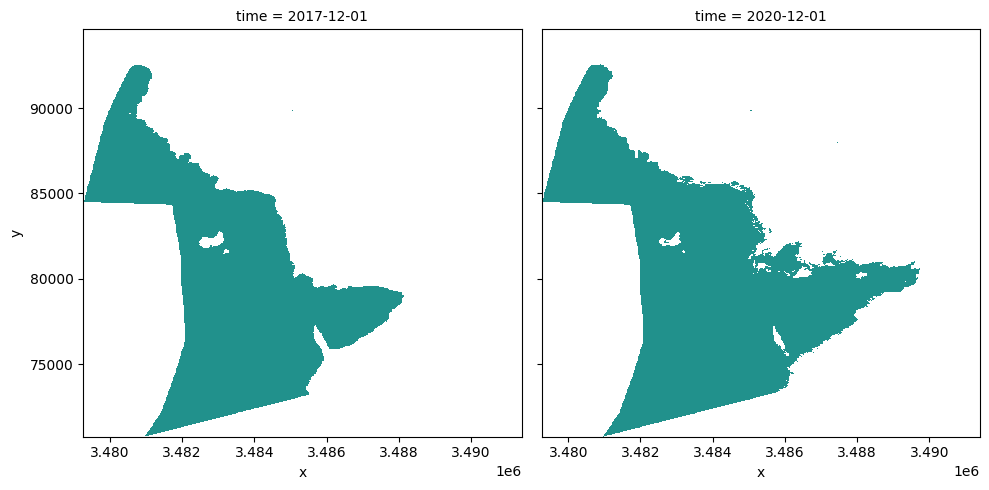

In [16]:
area_ds.sel(time=time_xr).plot(col="time", col_wrap=2, robust=True, figsize=(10, 5), cmap='viridis', add_colorbar=False);

## Animating time series
In the next cell, we plot the dataset we loaded above as an animation GIF, using the [`xr_animation`](../Frequently_used_code/Animated_timeseries.ipynb) function.
The `output_path` will be saved in the directory where the script is found and you can change the names to prevent files overwrite.

Exporting animation to results/water_extent.gif


  0%|          | 0/17 (0.0 seconds remaining at ? frames/s)

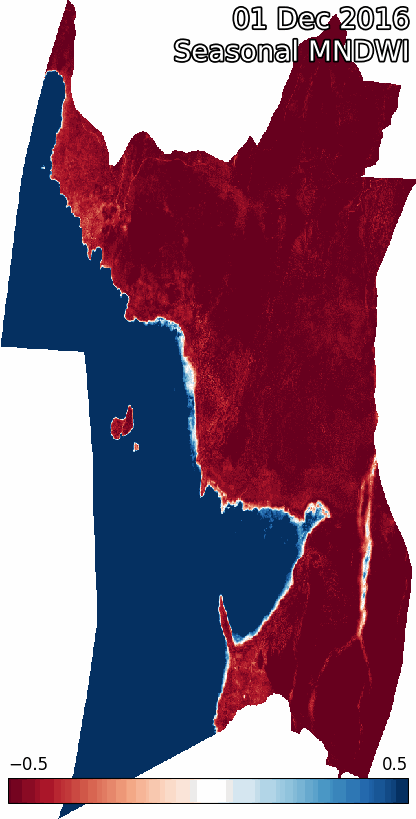

In [17]:
out_path = 'results/water_extent.gif'

xr_animation(ds=mndwi.to_dataset(name='MNDWI'), 
             output_path=out_path,
             bands = ['MNDWI'],
             show_text = 'Seasonal MNDWI',
             interval=300, 
             width_pixels=300,
             show_colorbar=True,
             imshow_kwargs={'cmap':'RdBu','vmin': -0.5, 'vmax': 0.5},
             colorbar_kwargs={'colors': 'black'}
            )

# Plot animated gif
plt.close()
Image(filename=out_path)

## Compare water extent between two periods

* `baseline_time` : The baseline year for the analysis
* `analysis_time` : The year to compare to the baseline year

* The water extent for the two time-periods are extracted from the datatset `ds_valid_water_area`

In [18]:
baseline_time = '2019-12-01'
analysis_time = '2020-12-01'

baseline_ds, analysis_ds = ds_valid_water_area.sel(time=baseline_time, method ='nearest'),ds_valid_water_area.sel(time=analysis_time, method ='nearest')

In [19]:
time_xr = xr.DataArray([baseline_ds.time.values, analysis_ds.time.values], dims=["time"])

## Plotting
Plot water extent of the MNDWI product for the two chosen periods.

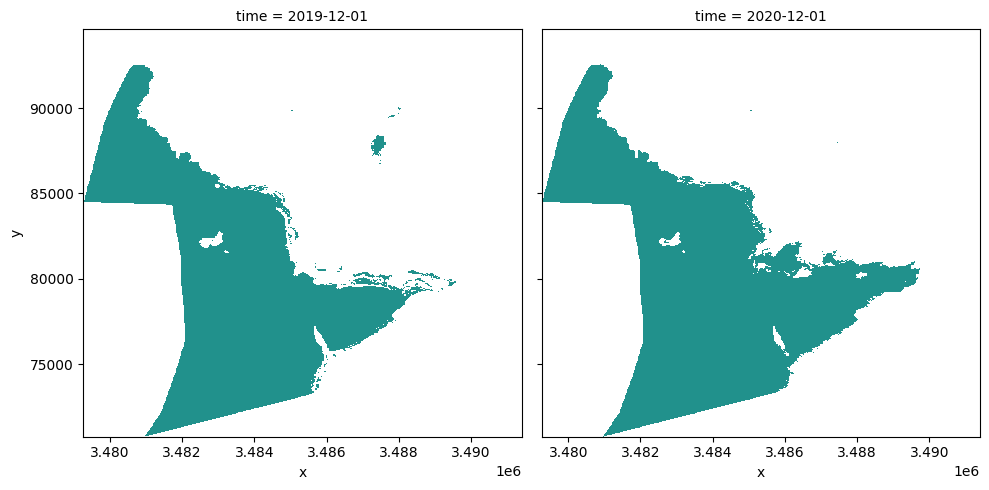

In [20]:
area_ds.sel(time=time_xr).plot(col="time", col_wrap=2, robust=True, figsize=(10, 5), cmap='viridis', add_colorbar=False);

### Calculate the change between the two nominated periods

The cells below calculate the amount of water gain, loss and stable for the two periods

In [21]:
# The two period Extract the two periods(Baseline and analysis) dataset from
ds_selected = area_ds.where(area_ds == 1, 0).sel(time=time_xr)

#The dataset array is transform to 1 and 0 using the `astype(int)` function.
analyse_total_value = ds_selected[1]
change = analyse_total_value - ds_selected[0]

#The various scenarios are extracted from the `change` variable for the two years
#Water gain  is 1
water_appeared = change.where(change == 1)

#Permanent water = 0
permanent_water = change.where((change == 0) & (analyse_total_value == 1))

#Permanent Land = 0
permanent_land = change.where((change == 0) & (analyse_total_value == 0))

#Water loss = -1
water_disappeared = change.where(change == -1)

The cell below calculate the area of water extent for water_loss, water_gain, permanent water and land 

In [22]:
total_area = analyse_total_value.count().values * area_per_pixel
water_apperaed_area = water_appeared.count().values * area_per_pixel
permanent_water_area = permanent_water.count().values * area_per_pixel
permanent_land_area = permanent_land.count().values * area_per_pixel
water_disappeared_area = water_disappeared.count().values * area_per_pixel

The cell below calculate the percentage of area of water extent for water_loss, water_gain, permanent water and land 

In [23]:
# Percentage Change in water extent
percentage_water_gain = round((water_apperaed_area /  total_area) * 100 , 2)
percentage_water_loss = round(water_disappeared_area /  total_area * 100 , 2)
percentage_permanent_water = round(permanent_water_area /  total_area * 100 , 2)
percentage_permanent_land = round(permanent_land_area /  total_area * 100, 2)

## Plot the changes
The water variables are plotted to visualised the result

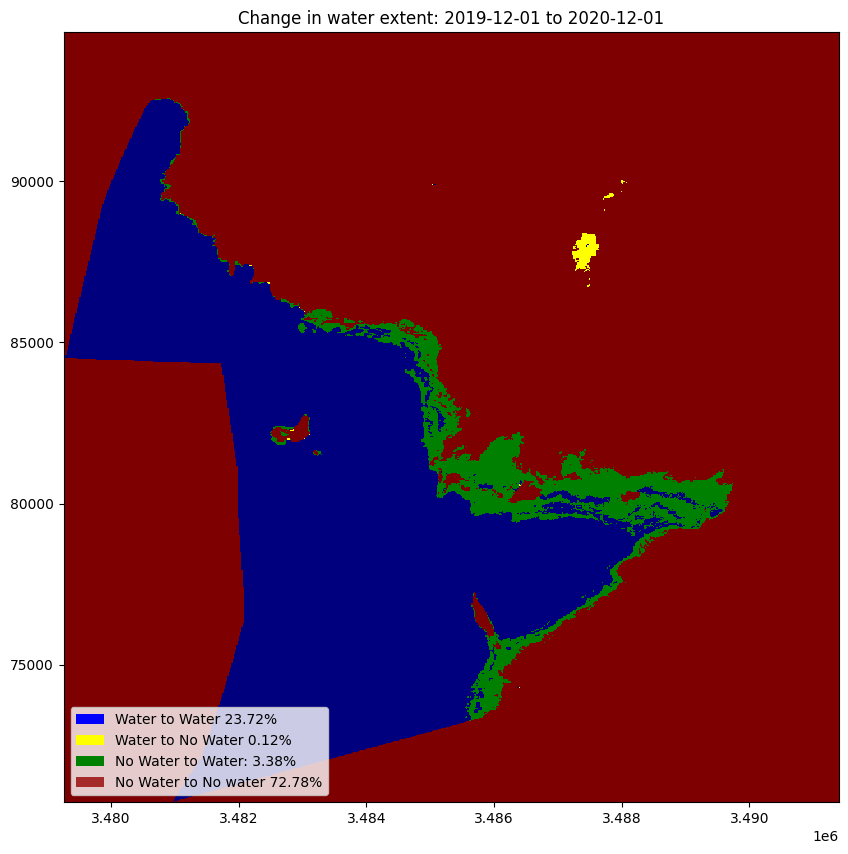

In [24]:
water_appeared_color = 'Green'
water_disappeared_color = 'Yellow'
stable_color = 'Blue'
land_color = 'Brown'

plot_aspect = image_aspect(area_ds)

ds_selected[1].plot.imshow(cmap='jet_r', add_colorbar=False, add_labels=False, figsize=(10,10))
water_appeared.plot.imshow(cmap=ListedColormap([water_appeared_color]), add_colorbar=False, add_labels=False)
water_disappeared.plot.imshow(cmap=ListedColormap([water_disappeared_color]), add_colorbar=False, add_labels=False)

plt.legend(
        [Patch(facecolor=stable_color), Patch(facecolor=water_disappeared_color), Patch(facecolor=water_appeared_color),   Patch(facecolor=land_color)], 
        [f'Water to Water {percentage_permanent_water}%', f'Water to No Water {percentage_water_loss}%' , f'No Water to Water: {percentage_water_gain}%',  
         f'No Water to No water {percentage_permanent_land}%'],
         loc = 'lower left'
    );

plt.title('Change in water extent: '+baseline_time+' to '+analysis_time);

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [25]:
print(datacube.__version__)

1.8.15


**Last Tested:**

In [26]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2023-08-21'